# What If Model Memory Is Reorganized Like Human Episodic recall?

In [1]:
# 1. Setup & Imports
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split
from typing import Tuple
from torch.optim import Adam
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt

# # EpiNet Encoder Module
## 1. **Import** the required libraries  
## 2. **Define** the `Encoder` class  
## 3. **Instantiate** the encoder and inspect its architecture  
## 4. **Run** a forward pass on a dummy image to verify output shape 

In [2]:
class Encoder(nn.Module):
    """Transforms input images into a latent embedding z."""
    def __init__(self, latent_dim: int = 128):
        super(Encoder, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # 28×28 → 28×28
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 28×28 → 14×14
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 14×14 → 14×14
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 14×14 → 7×7
            nn.Flatten(),     # → (64*7*7)
    )
        # Project flattened features to latent_dim
        self.project = nn.Linear(64 * 7 * 7, latent_dim)  # → z ∈ ℝᵈ
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.feature_extractor(x)
        z = self.project(features)
        return z # Matches “z ∈ ℝᵈ”

In [3]:
# Instantiate encoder to verify
encoder = Encoder(latent_dim=128)
print(encoder)
dummy = torch.randn(1, 1, 28, 28)
print("Output shape:", encoder(dummy).shape)

Encoder(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (project): Linear(in_features=3136, out_features=128, bias=True)
)
Output shape: torch.Size([1, 128])


# # MemoryController Module
# This defines and tests the `MemoryController` class, which computes
# biologically‐inspired salience decay:
# **Sections:** 
# 1. Define `MemoryController`  
# 2. Instantiate and Inspect  
# 3. Test `decay()` with dummy data  

In [3]:
# 3. MemoryController Module
class MemoryController:
    """
    Computes the biologically-inspired salience decay.
    salience_m = r * exp(–α · (τ_now – τ_m))

    Notation:
      • r      … initial salience score (r₀)
      • τ_m    … timestamp when memory m was stored
      • α      … decay rate (learnable or fixed)
      • salience_m … decayed salience at the current time
    """
    def __init__(self, alpha: float):
        """
        α: decay rate (higher → faster forgetting)
        """
        self.alpha = alpha

    def decay(self, r: torch.Tensor, tau_m: torch.Tensor) -> torch.Tensor:
        """
           Apply decay to a batch of memories.

        Args:
            r      (torch.Tensor): shape [M], initial salience scores for M memories
            tau_m  (torch.Tensor): shape [M], stored timestamps (in seconds) for each memory

        Returns:
            torch.Tensor of shape [M]:
              current salience_m = r * exp(–α · (τ_now – τ_m))
        """
        #  Current time in seconds, on same device as inputs
        tau_now = torch.tensor(time.time(), device=r.device)
        #  Δτ = τ_now – τ_m
        delta_tau = tau_now - tau_m
        #  Apply decay element-wise
        salience_m = r * torch.exp(-self.alpha * delta_tau)
        return salience_m

In [5]:
# ## Instantiate and Inspect
#
# Create a `MemoryController` with a chosen decay rate.

# %%
alpha = 0.003
mem_ctrl = MemoryController(alpha=alpha)
print(mem_ctrl)

In [6]:
# Test `decay()` with Dummy Data
# Dummy salience scores
r = torch.tensor([1.0, 0.5, 2.0], dtype=torch.float32)
# Simulate that these memories were stored 0s, 10s, and 20s ago
now = time.time()
tau_m = torch.tensor([now, now - 60, now - 180], dtype=torch.float32)

# Compute decayed saliences
decayed = mem_ctrl.decay(r, tau_m)
print("Initial r:     ", r)
print("Timestamps Δτ: ", (torch.tensor(time.time()) - tau_m))
print("Decayed salience:", decayed)

Initial r:      tensor([1.0000, 0.5000, 2.0000])
Timestamps Δτ:  tensor([  0., 128., 256.])
Decayed salience: tensor([1.0000, 0.3406, 0.9279])


# # EpisodicMemory Module
# This defines and tests the `EpisodicMemory` class, which stores a fixed‑capacity buffer of memories
# and evicts the lowest‑salience trace when full.
# **Sections:**
# 1. Define `EpisodicMemory`  
# 2. Instantiate and Inspect  
# 3. Test `add()` and Eviction Logic  

In [4]:
# 4. EpisodicMemory Module
class EpisodicMemory:
    """
    Fixed‑capacity buffer storing tuples, m = (z, c, r₀, τₘ, yₘ).
    admitting only the most salient memories over time.
    Admission & eviction are driven by current salience decay:
      • Admit new memory if under capacity,
      • Also stores task-ID t for task-aware recall.
      • Otherwise evict the memory with lowest decayed salience.
    """
    def __init__(
            self,
            capacity: int,
            latent_dim: int,
            decay_rate: float,
            device: torch.device
    ):
        """
        Args:
            capacity (int): maximum number of memories
            latent_dim (int): dimensionality of the latent space
            decay_rate (float): decay rate for salience decay
            device (torch.device): device to store the memory
        """
        self.capacity = capacity
        self.device = device

        # Memory buffer (initially empty)
        self.z_buffer = torch.empty((0, latent_dim), device=device) # z: [N × d] latent embeddings z
        self.c_buffer = torch.empty((0, latent_dim), device=device) # c: [N × d] context vectors
        self.r0_buffer = torch.empty((0,), device=device)  # r0: [N] initial salience score r₀
        self.tau_buffer = torch.empty((0,), device=device) # timestamps τₘ when stored
        self.y_buffer = torch.empty((0,), dtype=torch.long, device=device) # labels yₘ
        self.t_buffer   = torch.empty(0, dtype=torch.long, device=device)      # task-ID t
        

        # Reuse your MemoryController for decay
        self.mem_ctrl = MemoryController(decay_rate)

    def add(
            self,
            z: torch.Tensor,
            c: torch.Tensor,
            r0: float,
            y: torch.Tensor,
            task_id: int = 0  # default 0
    ):
        """
        Try to admit new memory (z,c,r0,τ,y,task_id).
        If at capacity, evict the lowest‐decayed‐salience memory.
        """
        # Preparing tensors for concatenation
        z = z.detach().to(self.device).view(1, -1)
        #c = c.detach().to(self.device).view(1, -1)
        c = F.normalize(c.detach().to(self.device).view(1, -1), dim=-1)
        r0 = torch.tensor([r0], device=self.device)
        y = y.detach().to(self.device).view(1)
        tau = torch.tensor([time.time()], device=self.device)
        t = torch.tensor([task_id], dtype=torch.long, device=self.device)

        # If under capacity, just append/admit
        if self.z_buffer.shape[0] < self.capacity:
            self._append(z, c, r0, tau, y, t)
            return

        # Otherwise compute decayed salience of existing memories
        s_existing = self.mem_ctrl.decay(self.r0_buffer, self.tau_buffer)
        idx_min = torch.argmin(s_existing).item()

        # If this new memory isn't more salience than the least one, skip
        if r0 <= s_existing[idx_min]:
            return

        # Else evict the lowest‐salience and replace it
        self._replace(idx_min, z, c, r0, tau, y, t)

    def _append(self, z, c, r0, tau, y, t):
        """Add a new memory at the end of each buffer."""
        self.z_buffer = torch.cat([self.z_buffer, z], dim=0)
        self.c_buffer = torch.cat([self.c_buffer, c], dim=0)
        self.r0_buffer = torch.cat([self.r0_buffer, r0], dim=0)
        self.tau_buffer = torch.cat([self.tau_buffer, tau], dim=0)
        self.y_buffer = torch.cat([self.y_buffer, y], dim=0)
        self.t_buffer   = torch.cat([self.t_buffer, t], dim=0)


    def _replace(self, idx, z, c, r0, tau, y, t):
        """Overwrite the memory at index `idx` with the new one."""
        self.z_buffer[idx] = z
        self.c_buffer[idx] = c
        self.r0_buffer[idx] = r0
        self.tau_buffer[idx] = tau
        self.y_buffer[idx] = y
        self.t_buffer[idx] = t

    # def clear(self):
    #     """Reset all buffers to empty."""
    #     self.__init__(self.capacity, self.z_buffer.size(1), self.mem_ctrl.alpha, self.device)

In [6]:
# ## Instantiate and Inspect
# Example: capacity=3, latent_dim=4
capacity   = 10
latent_dim = 9
decay_rate = 0.003
device = torch.device('cpu')

mem = EpisodicMemory(capacity, latent_dim, decay_rate, device)
print(mem)

In [7]:
# ## Test `add()` and Eviction Logic
# Create some dummy embeddings and labels
for i in range(15):
    z = torch.randn(latent_dim)
    c = torch.randn(latent_dim)
    y = torch.tensor(i % 2)           # binary labels
    r0 = float(i + 1)                 # increasing initial salience
    mem.add(z, c, r0, y)
    print(f"After adding memory {i+1}: buffer size = {mem.z_buffer.size(0)}")
    print("r0_buffer:", mem.r0_buffer.tolist())

# Final contents
print("\nFinal z_buffer shape:", mem.z_buffer.shape)
print("Final r0_buffer values:", mem.r0_buffer.tolist())

After adding memory 1: buffer size = 1
r0_buffer: [1.0]
After adding memory 2: buffer size = 2
r0_buffer: [1.0, 2.0]
After adding memory 3: buffer size = 3
r0_buffer: [1.0, 2.0, 3.0]
After adding memory 4: buffer size = 4
r0_buffer: [1.0, 2.0, 3.0, 4.0]
After adding memory 5: buffer size = 5
r0_buffer: [1.0, 2.0, 3.0, 4.0, 5.0]
After adding memory 6: buffer size = 6
r0_buffer: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
After adding memory 7: buffer size = 7
r0_buffer: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
After adding memory 8: buffer size = 8
r0_buffer: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
After adding memory 9: buffer size = 9
r0_buffer: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
After adding memory 10: buffer size = 10
r0_buffer: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
After adding memory 11: buffer size = 10
r0_buffer: [11.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
After adding memory 12: buffer size = 10
r0_buffer: [11.0, 12.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
A

# # RecallEngine Module
# This defines and tests the `RecallEngine` class, which retrieves the most
# salient memories based on cosine similarity with a query and decayed salience.
# **Sections:** 
# 1. Define `RecallEngine`  
# 2. Instantiate and Inspect  
# 3. Test `recall()` with Dummy Data  

In [5]:
# 5. RecallEngine Module
# - **top_k**: number of highest‑scoring memories to retrieve  
# - **RecallScoreₘ** = cos(z_t, cₘ) · salienceₘ  
# - **salienceₘ** = r₀ₘ · exp(–α·(τ_now – τₘ))  
# - **Recall embedding**: where the sum is over the Top‑K memories.

class RecallEngine:
    """
    Handles salience decay, scoring, and top-k retrieval from EpisodicMemory.
    Retrieves salient memories based on cosine similarity and decayed salience.

    Given a query embedding z_t and stored memories (z_m, c_m, r0_m, τ_m),
    computes for each memory:
      RecallScore_m = cos(z_t, c_m) * salience_m
    where salience_m = r0_m * exp(-α * (τ_now - τ_m)).
    Selects Top‑K memories by RecallScore, then computes recall embedding:
      r_t = (1 / Σ_i r_i) * Σ_i r_i * z_i,
    where r_i is the decayed salience of the selected memories.
    """
    def __init__(self, top_k: int):
        """
        top_k: number of highest‑scoring memories to retrieve.
        """
        self.top_k = int(top_k)

    def recall(self, z_query: torch.Tensor, memory: EpisodicMemory) -> torch.Tensor:
        """
        Perform memory recall for a batch of query embeddings.

        Args:
            z_query (torch.Tensor): shape [B, d], query latent embeddings z_t.
            memory (EpisodicMemory): contains buffers:
              - c_buffer: [N, d] context embeddings c_m
              - z_buffer: [N, d] latent embeddings z_m
              - r0_buffer: [N]   initial salience r0_m
              - tau_buffer: [N]  timestamps τ_m

        Returns:
            torch.Tensor: shape [B, d], recall embeddings r_t.
        """
        # Guard for empty memory
        if memory.z_buffer.size(0) == 0:
            return torch.zeros_like(z_query)

        if hasattr(memory, "current_task_id"):
            task_mask = (memory.t_buffer == memory.current_task_id).float()
        else:                            
            task_mask = torch.ones_like(memory.r0_buffer)

        # Compute decayed salience for all stored memories: [N]
        salience = memory.mem_ctrl.decay(memory.r0_buffer, memory.tau_buffer) * task_mask

        if salience.sum() == 0:
            return torch.zeros_like(z_query)

        # Compute cosine similarity: [B, N]
        cos_sim = F.cosine_similarity(
            z_query.unsqueeze(1),         # [B, 1, d]
            memory.c_buffer.unsqueeze(0),   # [1, N, d]
            dim=-1
        )

        # Compute recall scores for selection: [B, N]
        recall_scores = cos_sim * salience.unsqueeze(0)
        k = min(self.top_k, recall_scores.size(1))
        # Select Top-K indices by recall score: [B, K]
        _, top_idx = torch.topk(recall_scores, k, dim=1)

        # Gather salience and latent embeddings of selected memories
        salience_topk = salience[top_idx]          # [B, K]
        z_topk = memory.z_buffer[top_idx]   # [B, K, d]

        # Normalize by sum of salience: weights = r_i / Σ_j r_j
        weights = salience_topk / (salience_topk.sum(dim=1, keepdim=True) + 1e-8)

        # Weighted sum to form recall embedding: [B, d]
        recall_emb = (weights.unsqueeze(-1) * z_topk).sum(dim=1)
        return recall_emb

In [9]:
# ## Instantiate and Inspect

# Set up a small EpisodicMemory and RecallEngine
device     = torch.device('cpu')
latent_dim = 9
capacity   = 10
decay_rate = 0.003
top_k      = 2

memory      = EpisodicMemory(capacity, latent_dim, decay_rate, device)
recall_eng  = RecallEngine(top_k=top_k)

print(memory)
print(recall_eng)

In [10]:
# ## Test `recall()` with Dummy Data
# - Add 5 dummy memories with increasing initial salience  
# - Wait briefly to generate time differences  
# - Query with two random embeddings  

# %%
# Add dummy memories
for i in range(15):
    z = torch.randn(latent_dim)
    c = torch.randn(latent_dim)
    y = torch.tensor(i % 3)           # dummy labels
    r0 = float(i + 1)                 # salience increasing
    memory.add(z, c, r0, y)
    time.sleep(0.1)                   # small delay to vary τ_m

print("Stored r0_buffer:", memory.r0_buffer.tolist())

# Create a batch of 2 query embeddings
z_query = torch.randn(2, latent_dim)

# Perform recall
r_emb = recall_eng.recall(z_query, memory)

print("Query embeddings:\n", z_query)
print("Recall embeddings:\n", r_emb)

Stored r0_buffer: [11.0, 12.0, 13.0, 14.0, 15.0, 6.0, 7.0, 8.0, 9.0, 10.0]
Query embeddings:
 tensor([[-0.1209,  2.2177,  0.9869,  0.7662, -2.0156, -0.6407, -3.4923,  0.9472,
         -0.1894],
        [ 0.8518,  0.8953,  2.3671, -2.3030, -1.3263, -1.0925,  0.9189, -0.7212,
         -1.6953]])
Recall embeddings:
 tensor([[ 0.3074, -0.8994,  0.8240,  0.0182,  0.2814, -0.9189, -0.0514, -0.3084,
          0.1192],
        [ 0.3074, -0.8994,  0.8240,  0.0182,  0.2814, -0.9189, -0.0514, -0.3084,
          0.1192]])


# # Decoder Module for EpiNet
# This defines and tests the `Decoder` class, which takes a latent embedding `z_t`
# and a recall embedding `r_t`, concatenates them, and produces class logits via a two-layer MLP using Mixture of Experts MoE.
# **Sections:** 
# 1. Define `Decoder`  
# 2. Instantiate and Inspect  
# 3. Forward Pass Test  

In [6]:
#   - `z_t` ∈ ℝᵈ: latent embedding from the encoder  
#   - `r_t` ∈ ℝᵈ: recall embedding from the memory 
# Concatenate `[z_t; r_t]` → ℝ²ᵈ 

# 6. Decoder Module

class Decoder(nn.Module):
    """
    Mixture-of-Experts Decoder for EpiNet.

    Given latent embedding z_t and recall embedding r_t,
    concatenates to h_t ∈ ℝ^{2d}, then uses E parallel experts
    and a gating network to produce class logits:
      • Gate: g = softmax(G·h_t) ∈ ℝ^E
      • Experts: ℓ^{(e)} = expert_e(h_t) ∈ ℝ^K
      • logits = Σ_{e=1}^E g_e · ℓ^{(e)}
    """
    def __init__(
        self,
        latent_dim: int,
        hidden_dim: int,
        num_classes: int,
        num_experts: int = 4
    ):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.num_experts = num_experts
        # Gating network: 2d → E
        self.gate = nn.Linear(latent_dim * 2, num_experts)
        # Experts: each maps 2d → hidden_dim → num_classes
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(latent_dim * 2, hidden_dim),
                nn.ReLU(inplace=True),
                nn.Linear(hidden_dim, num_classes)
            ) for _ in range(num_experts)
        ])

    def forward(self, z: torch.Tensor, r: torch.Tensor) -> torch.Tensor:
        """
        Args:
          z (torch.Tensor): [B, d], latent embedding from Encoder
          r (torch.Tensor): [B, d], recall embedding from RecallEngine
        Returns:
          logits (torch.Tensor): [B, num_classes]
        """
        # Concatenate embeddings: [B, 2d]
        h = torch.cat([z, r], dim=1)
        # Compute gating weights: [B, E]
        gate_logits = self.gate(h)
        # gate_weights = F.softmax(gate_logits, dim=1)
        gate_weights = F.softmax(gate_logits, 1)
        # Expert outputs: stack into [B, E, K]
        expert_outputs = torch.stack(
            [expert(h) for expert in self.experts],
            dim=1
        )
        # Weighted sum of experts: [B, K]
        gate_weights = gate_weights.unsqueeze(-1)  # [B, E, 1]
        logits = (gate_weights * expert_outputs).sum(dim=1)
        return logits

In [12]:
# ## 3. Instantiate and Inspect

latent_dim = 128
hidden_dim = 256
num_classes = 10

decoder = Decoder(latent_dim, hidden_dim, num_classes)
print(decoder)

Decoder(
  (gate): Linear(in_features=256, out_features=4, bias=True)
  (experts): ModuleList(
    (0-3): 4 x Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=256, out_features=10, bias=True)
    )
  )
)


In [13]:
# ## Forward Pass Test
# Verify that concatenating two random embeddings produces correct logits shape.

# Dummy embeddings
z_dummy = torch.randn(4, latent_dim)  # batch size 4
r_dummy = torch.randn(4, latent_dim)

# Forward pass
logits = decoder(z_dummy, r_dummy)
print("z_dummy shape:", z_dummy.shape)
print("r_dummy shape:", r_dummy.shape)
print("logits shape:", logits.shape)

z_dummy shape: torch.Size([4, 128])
r_dummy shape: torch.Size([4, 128])
logits shape: torch.Size([4, 10])


# # EpiNetModel Notebook
# This puts together all components of EpiNet:
# **Encoder** → latent embedding $z_t$  
# **RecallEngine** + **EpisodicMemory** → recall embedding $r_t$  
# **Decoder** → class logits  
# **Joint loss**
# - Integrates Encoder → Recall → Decoder, and computes L_total = L_task + λ · L_replay
# - Instantiate and inspect  
# - Run a dummy forward (inference)  
# - Run a dummy forward (training loss + memory update)

In [7]:
# 7. EpiNetModel Assembly

class EpiNetModel(nn.Module):
    """
     EpiNetModel integrates:
      1) Encoder → latent embedding z_t
      2) RecallEngine/EpisodicMemory → recall embedding r_t
      3) Decoder → class logits
    Computes joint loss:
      L_total = L_task + λ·L_replay
    """
    def __init__(
        self,
        latent_dim:   int,
        hidden_dim:   int,
        num_classes:  int,
        capacity:     int,
        decay_rate:   float,
        top_k:        int,
        lambda_coef:  float,
        device:       torch.device | None = None
    ):
        super().__init__()
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.encoder       = Encoder(latent_dim)
        self.decoder       = Decoder(latent_dim, hidden_dim, num_classes)
        self.memory        = EpisodicMemory(capacity, latent_dim, decay_rate, self.device)
        self.recall_engine = RecallEngine(top_k)

        self.criterion   = nn.CrossEntropyLoss()
        self.lambda_coef = lambda_coef
        self.last_replay_loss = 0.0
        self.current_task_id: int = 0

        self.to(self.device)

    # Forward pass
    def forward(self, x: torch.Tensor, y: torch.Tensor | None = None) -> torch.Tensor:
        x = x.to(self.device)
        z = self.encoder(x)
        self.memory.current_task_id = self.current_task_id
        r = self.recall_engine.recall(z, self.memory)
        logits = self.decoder(z, r)

        # Inference path
        if y is None:
            return logits

        # Supervised task loss 
        y = y.to(self.device)
        loss_task = self.criterion(logits, y)

        # # Replay loss
        # salience_mem = self.memory.mem_ctrl.decay(
        #     self.memory.r0_buffer, self.memory.tau_buffer
        # )
        
        # replay loss: compute decayed salience and mask out current-task memories
        salience_mem = self.memory.mem_ctrl.decay(
            self.memory.r0_buffer,
            self.memory.tau_buffer
        )  # [N]

        salience_mem = salience_mem * (self.memory.t_buffer != self.current_task_id).float()
        
        cos_sim_mem = F.cosine_similarity(
            z.unsqueeze(1),
            self.memory.c_buffer.unsqueeze(0),
            dim=-1
        )
        recall_scores = cos_sim_mem * salience_mem.unsqueeze(0)

        loss_replay = torch.tensor(0.0, device=self.device)
        N = self.memory.z_buffer.size(0)
        if N:
            k = min(self.recall_engine.top_k, N)

            _, top_idx = torch.topk(recall_scores, k, dim=1)

            sal_topk = salience_mem[top_idx]              # [B,K]
            z_topk   = self.memory.z_buffer[top_idx]      # [B,K,d]
            y_topk   = self.memory.y_buffer[top_idx]      # [B,K]

            B, K, d = z_topk.shape
            z_flat  = z_topk.view(B*K, d)
            r_flat  = torch.zeros_like(z_flat)             # zero recall for replay
            y_flat  = y_topk.view(B*K)
            
            logits_mem = self.decoder(z_flat, r_flat)
            
            losses_mem = F.cross_entropy(
                logits_mem, y_flat, reduction='none'
            ).view(B, K)                                   # [B,K]

            weight_sum   = sal_topk.sum() + 1e-8        # weighted *mean* replay loss
            loss_replay  = (sal_topk * losses_mem).sum(dim=1, keepdim=True) / weight_sum # Normalizing (so Train_loss is on the same numeric scale as Val_loss.)
            loss_replay = loss_replay.mean()  # average over batch

        self.last_replay_loss = loss_replay.item()
        loss = loss_task + self.lambda_coef * loss_replay
  

        # Episodic memory update
        with torch.no_grad():
            for zi, yi, logit_i in zip(z, y, logits):
                per_loss = F.cross_entropy(
                    logit_i.unsqueeze(0),
                    yi.unsqueeze(0),
                    reduction='none'
                ).item()

                # Initial salience = tanh(individual loss)
                init_r0 = torch.tanh(torch.tensor(per_loss)).item()

                # Only store if sufficiently salient
                if init_r0 > 0.05:
                    # use zi both as latent and context
                    #self.memory.add(zi, zi, init_r0, yi)
                    # add new memory with correct task_id
                    self.memory.add(zi, zi, init_r0, yi, task_id=self.current_task_id)

        return loss

In [15]:
## Instantiate & Inspect
# Hyperparams for a quick smoke test

latent_dim = 16
hidden_dim = 32
num_classes = 10
capacity = 20
decay_rate = 0.003
top_k = 5
lambda_coef = 0.5
device = torch.device('cpu')
model = EpiNetModel(
latent_dim, hidden_dim, num_classes,
capacity, decay_rate, top_k, lambda_coef, device
)
print(model)

EpiNetModel(
  (encoder): Encoder(
    (feature_extractor): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (project): Linear(in_features=3136, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (gate): Linear(in_features=32, out_features=4, bias=True)
    (experts): ModuleList(
      (0-3): 4 x Sequential(
        (0): Linear(in_features=32, out_features=32, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=32, out_features=10, bias=True)
      )
    )
  )
  (criterion): CrossEntropyLoss()
)


In [16]:
## Dummy Forward (Inference)

#Batch of 4 MNIST‑style images

x_dummy = torch.randn(4, 1, 28, 28)
logits = model(x_dummy) # y=None → returns [4,10] logits
print("Logits shape:", logits.shape)

Logits shape: torch.Size([4, 10])


In [17]:
# 8. Quick Sanity Check
## Dummy Forward (Training Loss + Memory Update)

# Create dummy labels

y_dummy = torch.randint(0, num_classes, (4,))
loss = model(x_dummy, y_dummy)
print("Loss:", loss.item())
print("Memory buffer size after update:", model.memory.z_buffer.size(0))

Loss: 2.267249584197998
Memory buffer size after update: 4


# # Split‑MNIST Data Loading & Visualization
# This notebook shows how to:
# - Define and use `train_test_split_loader` to get 80/10/10 train‑validate-test splits for digits 0–3, 4-6 and 7–9.  
# - Visualize a few examples from each split.

In [8]:
# 9. Define the DataLoader Function

def train_test_split_loader(
    batch_size:  int,
    num_workers: int  = 4,
    pin_memory:  bool = True,
    val_frac: float = 0.1,
    test_frac: float = 0.1,
)-> Tuple[DataLoader, ...]:
    """
    Returns SIX DataLoaders:
      Task-1 (digits 0-3): train1, val1, test1
      Task-2 (digits 4-6): train2, val2, test2
      Task-3 (digits 7-9): train3, val3, test3
    Each subset is split train/val/test in the ratio
      (1 − val_frac − test_frac)  :  val_frac  :  test_frac.
    """
    assert 0 < val_frac < 1 and 0 < test_frac < 1 and val_frac + test_frac < 1

    # Transform
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ])

    # --- load MNIST --------------------------------------------------------
    full = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    targets = full.targets

    idx_t1 = ((targets >= 0) & (targets <= 3)).nonzero(as_tuple=True)[0]  # 0,1,2,3
    idx_t2 = ((targets >= 4) & (targets <= 6)).nonzero(as_tuple=True)[0]  # 4,5,6
    idx_t3 = ((targets >= 7) & (targets <= 9)).nonzero(as_tuple=True)[0]  # 7,8,9

    ds1, ds2, ds3 = map(Subset, (full, full, full), (idx_t1, idx_t2, idx_t3))

    # --- helper to split one subset into train/val/test --------------------
    def split(ds):
        n        = len(ds)
        n_test   = int(n * test_frac)
        n_val    = int(n * val_frac)
        n_train  = n - n_val - n_test
        return random_split(ds, [n_train, n_val, n_test])

    train1_ds, val1_ds, test1_ds = split(ds1)
    train2_ds, val2_ds, test2_ds = split(ds2)
    train3_ds, val3_ds, test3_ds = split(ds3)

    # --- DataLoaders -------------------------------------------------------
    loader_args = dict(batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory)

    def loaders(tr, va, te):
        return (DataLoader(tr, shuffle=True,  **loader_args),
                DataLoader(va, shuffle=False, **loader_args),
                DataLoader(te, shuffle=False, **loader_args))

    return (*loaders(train1_ds, val1_ds, test1_ds),
            *loaders(train2_ds, val2_ds, test2_ds),
            *loaders(train3_ds, val3_ds, test3_ds))

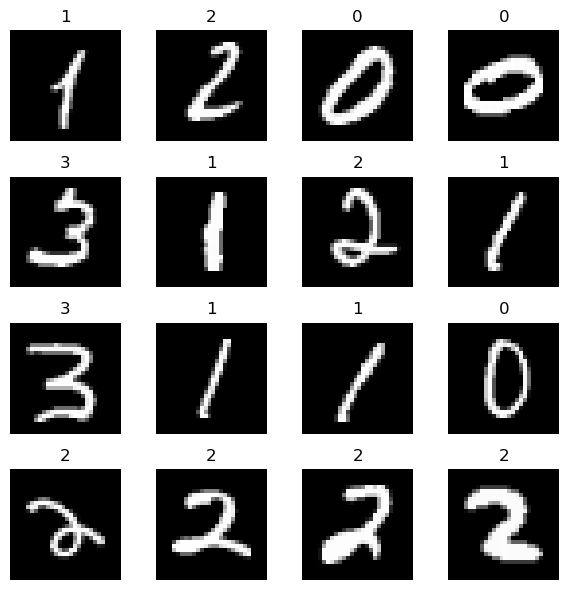

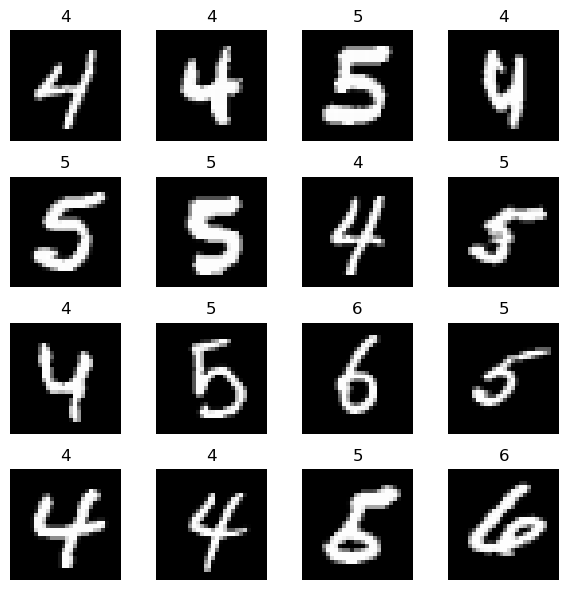

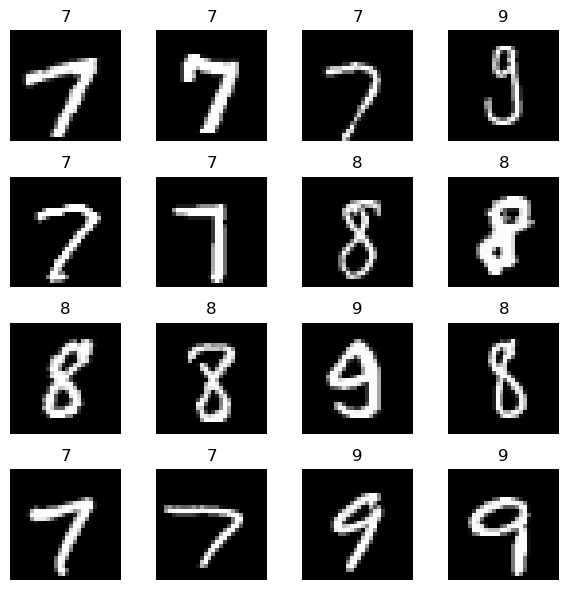

In [9]:
# ## Load Data

batch_size = 16
(train1, val1, test1,
 train2, val2, test2,
 train3, val3, test3) = train_test_split_loader(batch_size=batch_size)

# ## 1. Visualize Samples from Task 1 (digits 0–4)
# Get one batch
images, labels = next(iter(train1))

# Plot a 4×4 grid
images, labels = next(iter(train1))
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for ax, img, lab in zip(axes.flatten(), images, labels):
    ax.imshow(img.squeeze(0), cmap='gray')
    ax.set_title(f"{lab.item()}")
    ax.axis('off')
plt.tight_layout(); plt.show()


# ## 2. Visualize Samples from Task 2 (digits 4–6)

images, labels = next(iter(train2))
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for ax, img, lab in zip(axes.flatten(), images, labels):
    ax.imshow(img.squeeze(0), cmap='gray')
    ax.set_title(f"{lab.item()}")
    ax.axis('off')
plt.tight_layout(); plt.show()

# ## 3. Visualize Samples from Task 2 (digits 7–9)
images, labels = next(iter(train3))
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for ax, img, lab in zip(axes.flatten(), images, labels):
    ax.imshow(img.squeeze(0), cmap='gray')
    ax.set_title(f"{lab.item()}")
    ax.axis('off')
plt.tight_layout(); plt.show()

# # EpiNet Split‑MNIST Training
# This trains and evaluates the EpiNet model on the Split‑MNIST benchmark,
# using an 80/10/10 train‑validate-test split for each task (digits 0–3, 4-6 and 7–9) and joint task + replay loss.
# **Sections:**  
# - Evaluation Function  
# - Train‑One‑Task Helper  
# - Hyperparameters  
# - Load Data  
# - Instantiate Model, Optimizer & Scaler  
# - Train on Task 1  
# - Train on Task 2  
# - Final Joint Evaluation  
# - Save Model  

=== Task 1 ===


/Users/user/miniconda3/envs/py3_env/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/Users/user/miniconda3/envs/py3_env/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[Task1] Epoch01/10  Train_loss 0.1816  (replay 0.000)  Val_loss 0.0770  Val_acc 0.9745  Test_acc 0.9749  Memory  4206  Recall_score 0.281
[Task1] Epoch02/10  Train_loss 0.0288  (replay 0.000)  Val_loss 0.0352  Val_acc 0.9899  Test_acc 0.9871  Memory  5072  Recall_score 0.235
[Task1] Epoch03/10  Train_loss 0.0177  (replay 0.000)  Val_loss 0.0235  Val_acc 0.9919  Test_acc 0.9939  Memory  5629  Recall_score 0.211
[Task1] Epoch04/10  Train_loss 0.0230  (replay 0.000)  Val_loss 0.0417  Val_acc 0.9883  Test_acc 0.9931  Memory  6133  Recall_score 0.058
[Task1] Epoch05/10  Train_loss 0.0207  (replay 0.000)  Val_loss 0.0184  Val_acc 0.9956  Test_acc 0.9960  Memory  6627  Recall_score 0.043
[Task1] Epoch06/10  Train_loss 0.0149  (replay 0.000)  Val_loss 0.0252  Val_acc 0.9919  Test_acc 0.9931  Memory  6989  Recall_score 0.034
[Task1] Epoch07/10  Train_loss 0.0096  (replay 0.000)  Val_loss 0.0302  Val_acc 0.9931  Test_acc 0.9968  Memory  7229  Recall_score 0.035
[Task1] Epoch08/10  Train_loss 0.0

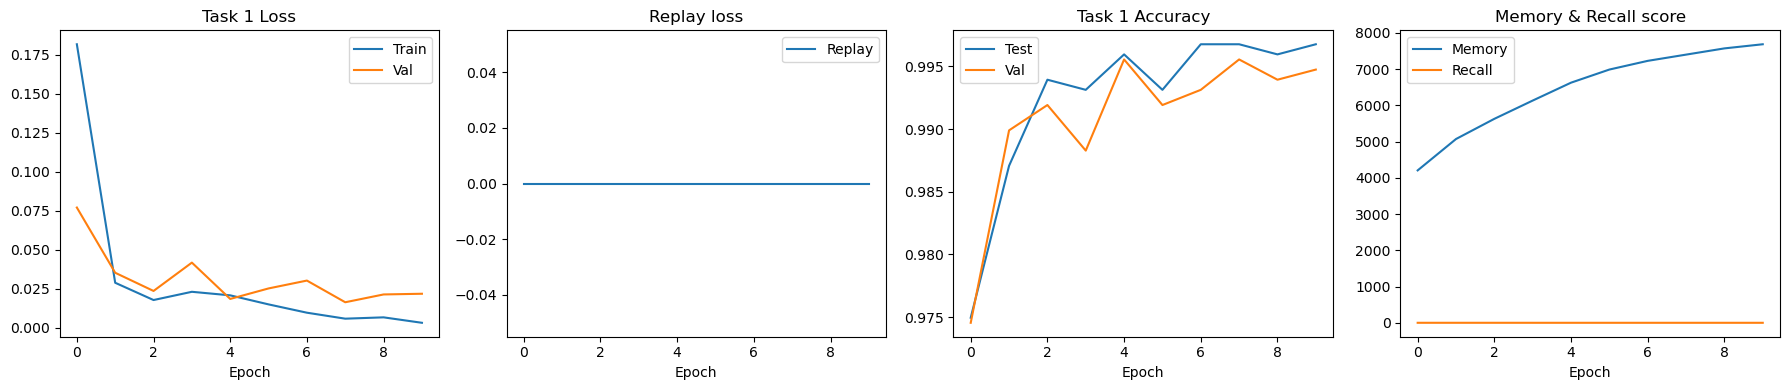

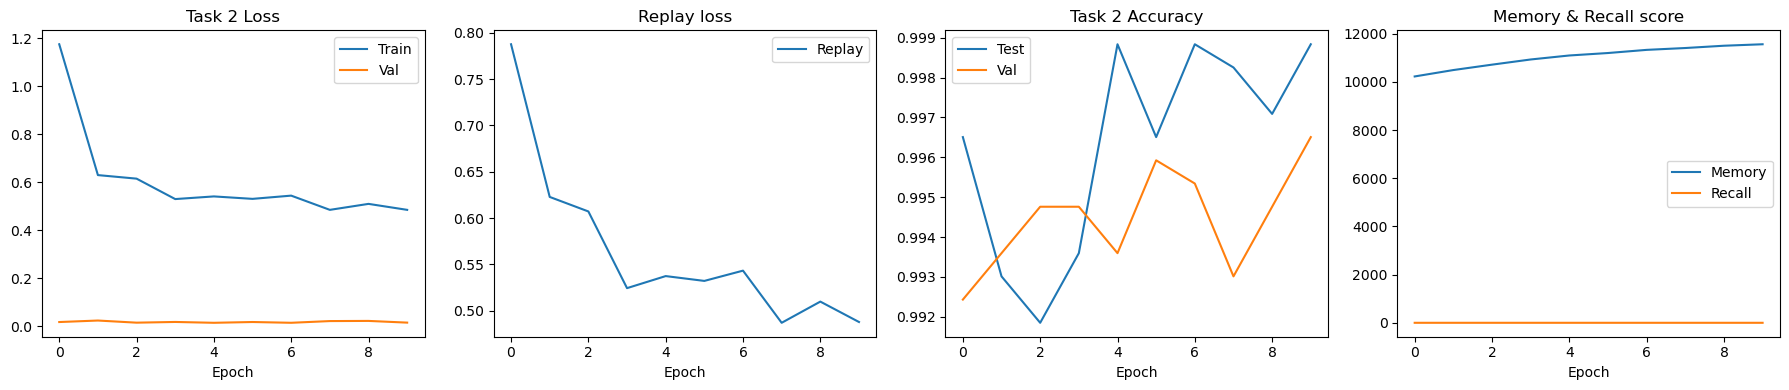

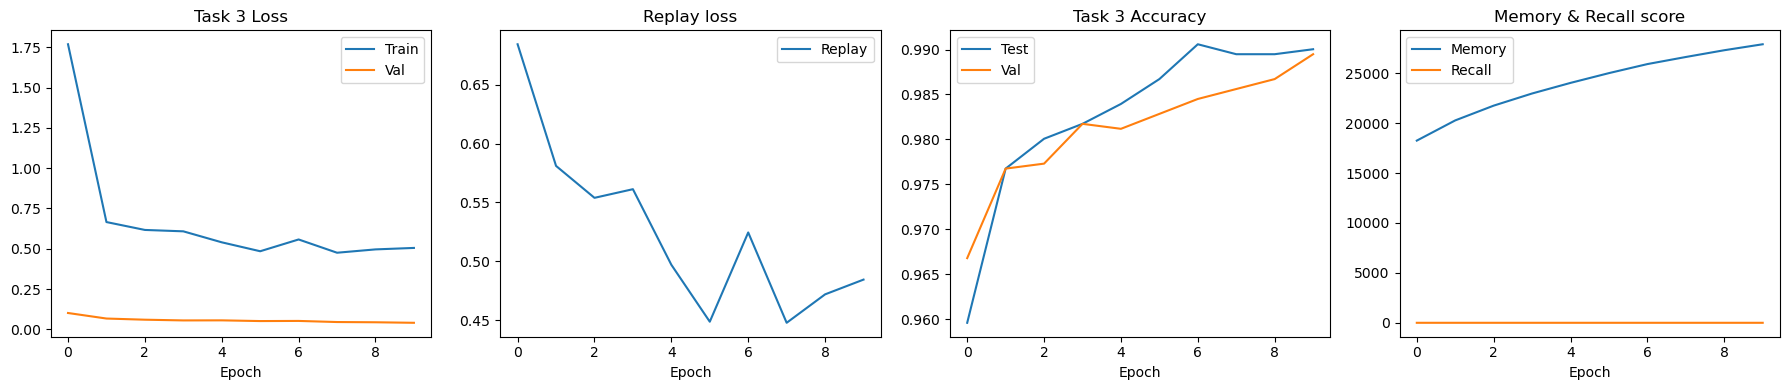

Model saved → epinet_split_mnist.pth


In [10]:
# 10. Full Training Loop (Split-MNIST) + Visualization

# . Evaluation Function  

def evaluate(model: torch.nn.Module, loader: DataLoader, device: torch.device, task_id: int | None = None) -> float:
    """
    Compute classification accuracy of `model` on data from `loader`.
    If task_id is given, temporarily sets
    model.current_task_id so the recall mask uses the right memories.
    """
    model.eval()
    prev_tid = model.current_task_id   # Remember state
    if task_id is not None:
        model.current_task_id = task_id
        
    correct = total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = torch.argmax(model(x), dim=1)
            correct += (preds == y).sum().item()
            total   += y.size(0)
    if task_id is not None:                    # restore state
        model.current_task_id = prev_tid
    return correct / total if total else 0.0

# λ-schedule  (linear warm-up over first 3 epochs)
def lambda_schedule(epoch: int, warmup_epochs=3, lambda_coef_max=0.5) -> float:
    return min(lambda_coef_max, lambda_coef_max * epoch / warmup_epochs)


# . Train‑One‑Task Helper  
def train_one_task(
    task_id:      int,
    train_loader: DataLoader,
    val_loader:   DataLoader,
    test_loader:  DataLoader,
    model:        torch.nn.Module,
    optimizer:    torch.optim.Optimizer,
    scaler:       GradScaler,
    device:       torch.device,
    epochs:       int,
    hist:         dict
):

    # History keys
    k_loss, k_vloss = f"loss_t{task_id}", f"vloss_t{task_id}"
    k_acc,  k_vacc  = f"acc_t{task_id}",  f"vacc_t{task_id}"
    k_mem,  k_rec   = f"mem_t{task_id}",  f"rec_t{task_id}"
    k_rpl           = f"rpl_t{task_id}"
    
    print(f"=== Task {task_id} ===")
    for ep in range(1, epochs + 1):
        #  Training
        model.current_task_id = task_id           
        model.lambda_coef = lambda_schedule(ep)
        model.train()
        running_loss = 0.0
        running_rpl  = 0.0
        n_batches    = 0
        for x, y in train_loader:
            optimizer.zero_grad()

            replay_ratio = 0.1                      # 33 % old, 75 % new
            n_rpl = int(replay_ratio * x.size(0))     # how many replay items
        
            if n_rpl and model.memory.z_buffer.size(0):
                # 1-A. pick indices of memories *not* from the current task
                mask = (model.memory.t_buffer != task_id)          # [N] bool
                pool = torch.nonzero(mask).squeeze(1)              # candidate rows
                # guard against pool == 0 (extremely early epochs)
                if pool.numel():
                    idx  = pool[torch.randperm(len(pool))[:n_rpl]] # random sample
        
                    # 1-B. get stored latents (z) and labels (y)
                    z_rpl  = model.memory.z_buffer[idx]            # [n_rpl, d]
                    y_rpl  = model.memory.y_buffer[idx]            # [n_rpl]
        
                    # 1-C. decode them with ZERO recall; no gradient to memory
                    r_zero = torch.zeros_like(z_rpl)
                    logits_rpl = model.decoder(z_rpl, r_zero)      # [n_rpl, K]
        
                    # 1-D. cross-entropy loss on replay logits
                    loss_rpl_direct = F.cross_entropy(logits_rpl, y_rpl)
                else:
                    loss_rpl_direct = torch.tensor(0.0, device=device)
            else:
                loss_rpl_direct = torch.tensor(0.0, device=device)
            
            
            with autocast():
                loss = model(x.to(device), y.to(device))     # batch-mean loss
            # 3. add the direct replay-batch loss we just computed
            loss = loss + loss_rpl_direct
            running_rpl += model.last_replay_loss + loss_rpl_direct.item()
            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()

            running_loss += loss.item()    # accumulate *batch* loss
            n_batches    += 1

        avg_loss = running_loss / n_batches   # mean over all batches
        avg_rpl  = running_rpl  / n_batches

        # Validation
        model.eval()
        val_sum = val_items = correct = 0
        with torch.no_grad():
            for xv, yv in val_loader:
                xv, yv = xv.to(device), yv.to(device)
                logits_v = model(xv)
                val_sum += torch.nn.functional.cross_entropy(
                              logits_v, yv, reduction='sum').item()
                val_items += yv.size(0)
                correct   += (torch.argmax(logits_v, 1) == yv).sum().item()
        avg_vloss = val_sum / val_items
        val_acc   = correct / val_items

        # Test accuracy
        #test_acc = evaluate(model, test_loader, device)
        # Test accuracy
        test_acc = evaluate(model, test_loader, device, task_id=task_id)

        # Memory / recall
        mem_sz = model.memory.z_buffer.size(0)
        recall_score = 0.0
        if mem_sz:
            with torch.no_grad():
                sal = model.memory.mem_ctrl.decay(
                          model.memory.r0_buffer, model.memory.tau_buffer)
                xs, _  = next(iter(train_loader))
                zs     = model.encoder(xs[:32].to(device))
                cos    = torch.nn.functional.cosine_similarity(
                            zs.unsqueeze(1),
                            model.memory.c_buffer[: zs.size(0)].unsqueeze(0), dim=-1)
                recall_score = (cos * sal[:cos.size(1)].unsqueeze(0)).mean().item()

        # History 
        hist[k_loss ].append(avg_loss)
        hist[k_vloss].append(avg_vloss)
        hist[k_rpl ].append(avg_rpl)
        hist[k_acc  ].append(test_acc)
        hist[k_vacc].append(val_acc)
        hist[k_mem  ].append(mem_sz)
        hist[k_rec  ].append(recall_score)

        # Log line
        print(f"[Task{task_id}] Epoch{ep:02d}/{epochs}  "
              f"Train_loss {avg_loss:.4f}  (replay {avg_rpl:.3f})  "
              f"Val_loss {avg_vloss:.4f}  Val_acc {val_acc:.4f}  "
              f"Test_acc {test_acc:.4f}  Memory {mem_sz:5d}  Recall_score {recall_score:.3f}")
    print()

# . Hyperparameters  

batch_size      = 128
latent_dim      = 128
hidden_dim      = 256
num_classes     = 10
capacity        = 100000
decay_rate      = 1e-4
top_k           = 64
lambda_coef     = 2.0
lr              = 1e-3
epochs_per_task = 10
num_workers     = 4
pin_memory      = True
val_frac        = 0.1
test_frac       = 0.1


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# . Load Data  

(train1, val1, test1,
 train2, val2, test2,
 train3, val3, test3) = train_test_split_loader(
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=pin_memory,
    val_frac=val_frac,
    test_frac=test_frac
)

# . Instantiate Model, Optimizer & Scaler  

model = EpiNetModel(
    latent_dim=latent_dim,
    hidden_dim=hidden_dim,
    num_classes=num_classes,
    capacity=capacity,
    decay_rate=decay_rate,
    top_k=top_k,
    lambda_coef=lambda_coef,
    device=device
).to(device)

optimizer = Adam(model.parameters(), lr=lr)
scaler    = GradScaler()

# history container/Dict
hist = {k: [] for k in
        ("loss_t1 vloss_t1 rpl_t1 acc_t1 vacc_t1 mem_t1 rec_t1 "
         "loss_t2 vloss_t2 rpl_t2 acc_t2 vacc_t2 mem_t2 rec_t2 "
         "loss_t3 vloss_t3 rpl_t3 acc_t3 vacc_t3 mem_t3 rec_t3").split()}

# ## . Train on Task 1  
train_one_task(1, train1, val1, test1, model, optimizer, scaler, device, epochs_per_task, hist)

# ## . Train on Task 2  
train_one_task(2, train2, val2, test2, model, optimizer, scaler, device, epochs_per_task, hist)

# ## . Train on Task 3 
train_one_task(3, train3, val3, test3, model, optimizer, scaler, device, epochs_per_task, hist)

# ## . Final Joint Evaluation  

# --- final joint test loop ---
print("\n=== Final Joint Test Accuracy ===")
for tid, te in zip((1, 2, 3), (test1, test2, test3)):
    acc = evaluate(model, te, device, task_id=tid)
    print(f"Task{tid} accuracy: {acc:.4f}")

def plot_history(tid):
    loss, vloss = hist[f"loss_t{tid}"], hist[f"vloss_t{tid}"]
    rpl = hist[f"rpl_t{tid}"]
    acc,  vacc = hist[f"acc_t{tid}"],  hist[f"vacc_t{tid}"]
    mem,  rec  = hist[f"mem_t{tid}"],  hist[f"rec_t{tid}"]

    fig, ax = plt.subplots(1, 4, figsize=(18, 4))
    ax[0].plot(loss, label="Train"); ax[0].plot(vloss, label="Val"); ax[0].legend()
    ax[0].set_title(f"Task {tid} Loss")

    ax[1].plot(rpl,  label="Replay"); ax[1].legend(); ax[1].set_title("Replay loss")

    ax[2].plot(acc, label="Test"); ax[2].plot(vacc, label="Val"); ax[2].legend()
    ax[2].set_title(f"Task {tid} Accuracy")

    ax[3].plot(mem, label="Memory"); ax[3].plot(rec, label="Recall"); ax[3].legend()
    ax[3].set_title("Memory & Recall score")

    for a in ax: a.set_xlabel("Epoch")
    plt.tight_layout(); plt.show()

plot_history(1); plot_history(2); plot_history(3)


# %% [markdown]
# ## 11.  Save model

# %%
torch.save(model.state_dict(), "epinet_split_mnist.pth")
print("Model saved → epinet_split_mnist.pth")

Accuracy matrix A:
 [[0.9943 0.992  0.989 ]
 [0.34   0.993  0.9895]
 [0.33   0.35   0.9878]]
Per‑task forgetting (BWT components): [0.0053 0.0035]
Average BWT: 0.0043999999999999595
Per‑task forward transfer: [0.007 0.017]
Average FWT: 0.011999999999999983


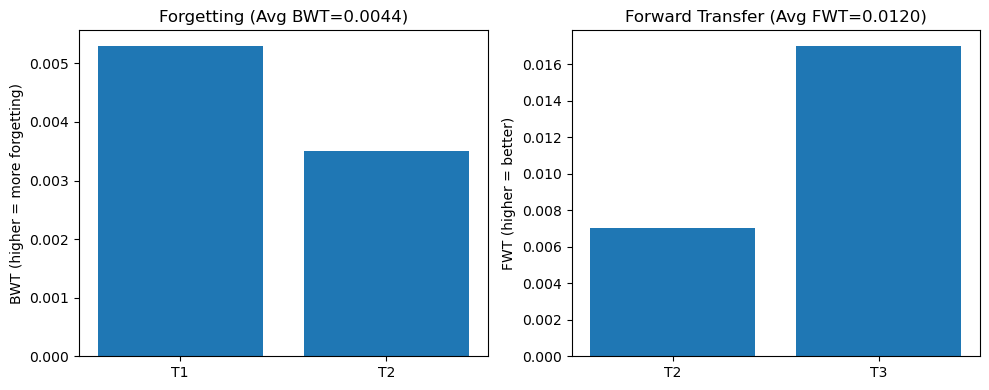

In [25]:
# Accuracy matrix for EpiNet after fixes
A = np.array([[0.9943, 0.9920, 0.9890],   # Task‑1
              [0.3400, 0.9930, 0.9895],   # Task‑2
              [0.3300, 0.3500, 0.9878]])  # Task‑3

T = A.shape[0]

# Backward Transfer (forgetting)
forgetting = A.diagonal() - A[:, -1]
avg_bwt = forgetting[:-1].mean()

# Forward Transfer (vs random baseline)
# random baseline per task: 1/|classes|, here T1=0.25, T2=0.333, T3=0.333
baseline = np.array([0.25, 0.333, 0.333])
fwt = np.zeros(T)
for i in range(1, T):
    fwt[i] = A[i, i-1] - baseline[i]
avg_fwt = fwt[1:].mean()

# Plot
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].bar([f"T{i+1}" for i in range(T-1)], forgetting[:-1])
ax[0].set_title(f"Forgetting (Avg BWT={avg_bwt:.4f})")
ax[0].set_ylabel("BWT (higher = more forgetting)")

ax[1].bar([f"T{i+1}" for i in range(1,T)], fwt[1:])
ax[1].set_title(f"Forward Transfer (Avg FWT={avg_fwt:.4f})")
ax[1].set_ylabel("FWT (higher = better)")

plt.tight_layout()

# print metrics
print("Accuracy matrix A:\n", A)
print("Per‑task forgetting (BWT components):", forgetting[:-1])
print("Average BWT:", avg_bwt)
print("Per‑task forward transfer:", fwt[1:])
print("Average FWT:", avg_fwt)

Accuracy matrix A:
 [[0.9943 0.9920 0.9890]
 [0.3400 0.9930 0.9895]
 [0.3300 0.3500 0.9878]]

Per‑task forgetting (BWT components): ['0.0053', '0.0035']
Average BWT: 0.0044

Per‑task forward transfer: ['0.0070', '0.0170']
Average FWT: 0.012


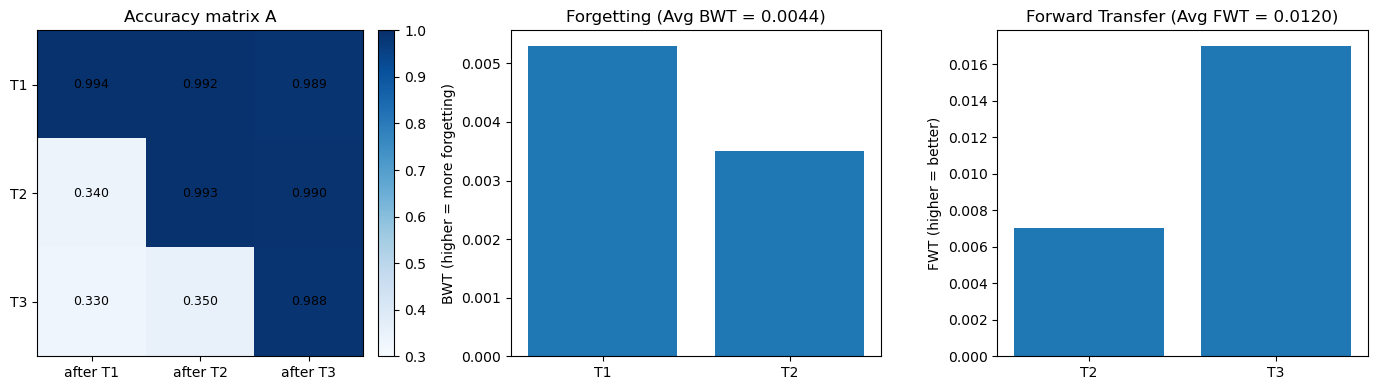

In [26]:
# --- 1. Accuracy matrix from the worked example ---------------------------
A = np.array([[0.9943, 0.9920, 0.9890],   # Task‑1 accuracy over time
              [0.3400, 0.9930, 0.9895],   # Task‑2 accuracy
              [0.3300, 0.3500, 0.9878]])  # Task‑3 accuracy

T = A.shape[0]

# --- 2. Backward Transfer (forgetting) ------------------------------------
forgetting = A.diagonal() - A[:, -1]      # F_i per task
avg_bwt = forgetting[:-1].mean()

# --- 3. Forward Transfer --------------------------------------------------
baseline = np.array([0.25, 0.333, 0.333]) # random‑guess for each subset
fwt = np.zeros(T)
for i in range(1, T):
    fwt[i] = A[i, i-1] - baseline[i]
avg_fwt = fwt[1:].mean()

# --- 4. Plotting ----------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# 4‑a Heat‑map of accuracy matrix
im = axes[0].imshow(A, cmap='Blues', vmin=0.3, vmax=1.0)
for i in range(T):
    for j in range(T):
        axes[0].text(j, i, f"{A[i, j]:.3f}", ha='center', va='center', fontsize=9, color='black')
axes[0].set_xticks(range(T)); axes[0].set_yticks(range(T))
axes[0].set_xticklabels([f"after T{j+1}" for j in range(T)])
axes[0].set_yticklabels([f"T{i+1}" for i in range(T)])
axes[0].set_title("Accuracy matrix A")
plt.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)

# 4‑b Forgetting bar chart
axes[1].bar([f"T{i+1}" for i in range(T-1)], forgetting[:-1])
axes[1].set_title(f"Forgetting (Avg BWT = {avg_bwt:.4f})")
axes[1].set_ylabel("BWT (higher = more forgetting)")

# 4‑c Forward transfer bar chart
axes[2].bar([f"T{i+1}" for i in range(1, T)], fwt[1:])
axes[2].set_title(f"Forward Transfer (Avg FWT = {avg_fwt:.4f})")
axes[2].set_ylabel("FWT (higher = better)")

plt.tight_layout()

# --- 5. Print the metrics -------------------------------------------------
print("Accuracy matrix A:\n", np.array2string(A, formatter={'float_kind':lambda x: f'{x:0.4f}'}))
print("\nPer‑task forgetting (BWT components):", [f"{f:.4f}" for f in forgetting[:-1]])
print("Average BWT:", round(avg_bwt, 4))
print("\nPer‑task forward transfer:", [f"{v:.4f}" for v in fwt[1:]])
print("Average FWT:", round(avg_fwt, 4))

In [11]:
# Count how many memories belong to each task

vals, counts = torch.unique(model.memory.t_buffer, return_counts=True)
print({int(v.item()): int(c.item()) for v, c in zip(vals, counts)})

{1: 7687, 2: 3880, 3: 16326}


In [12]:
# Average salience per task

task_ids = model.memory.t_buffer.cpu()
sal      = model.memory.mem_ctrl.decay(model.memory.r0_buffer, model.memory.tau_buffer).cpu()
for t in (1,2,3):
    sel = (task_ids == t)
    print(f"Task {t}  memories={sel.sum()}  avg_salience={sal[sel].mean():.6f}")

Task 1  memories=7687  avg_salience=0.158664
Task 2  memories=3880  avg_salience=0.218093
Task 3  memories=16326  avg_salience=0.266768
